In [14]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

if 'ipykernel' in sys.modules:
    ROOT_DIR = Path.cwd().parent
else:
    ROOT_DIR = Path(__file__).resolve().parent

DATA_PATH = ROOT_DIR / "data" / "processed" / "merged_data.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset loaded successfully!")
print(df.head())

Dataset loaded successfully!
       pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0  2016-03-14 17:24:55        -73.982155        40.767937         -73.964630   
1  2016-06-12 00:43:35        -73.980415        40.738564         -73.999481   
2  2016-01-19 11:35:24        -73.979027        40.763939         -74.005333   
3  2016-04-06 19:32:31        -74.010040        40.719971         -74.012268   
4  2016-03-26 13:30:55        -73.973053        40.793209         -73.972923   

   dropoff_latitude  passenger_count  hour  day        date             zone  \
0         40.765602                1    17    0  2016-03-14  Electronic City   
1         40.731152                1     0    6  2016-06-12        Jayanagar   
2         40.710087                1    11    1  2016-01-19       Whitefield   
3         40.706718                1    19    2  2016-04-06      Indiranagar   
4         40.782520                1    13    5  2016-03-26           Hebbal   

  weather

In [15]:
print("Missing values before cleaning:\n", df.isnull().sum())

for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(exclude=[np.number]).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values handled successfully.")
print(df.isnull().sum())



Missing values before cleaning:
 pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
date                 0
zone                 0
weather              0
temperature          0
traffic              0
surge_label          0
dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8500\3873506561.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8500\3873506561.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 


Missing values handled successfully.
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
date                 0
zone                 0
weather              0
temperature          0
traffic              0
surge_label          0
dtype: int64


In [23]:
def calculate_surge_label(row):
    zone = str(row["zone"])
    weather = str(row["weather"])

    zone_weights = {
        "Indiranagar": 1.0, "Koramangala": 1.0, "MG Road": 1.0,
        "Whitefield": 0.9, "Bellandur": 0.9, "Marathahalli": 0.8,
        "HSR Layout": 0.8, "BTM Layout": 0.7, "Electronic City": 0.7,
        "Jayanagar": 0.7, "Banashankari": 0.6, "Rajajinagar": 0.6,
        "Hebbal": 0.6, "Yelahanka": 0.5, "Basavanagudi": 0.5
    }
    
    weather_weights = {
        "Clear": 0.1, "Mist": 0.4, "Fog": 0.6,
        "Clouds": 0.2, "Rain": 1.0, "Thunderstorm": 1.0, "Drizzle": 0.8
    }

    z_weight = zone_weights.get(zone, 0.5) 
    w_weight = weather_weights.get(weather, 0.2)

    hour = row["hour"]
    if 7 <= hour <= 10 or 17 <= hour <= 21:
        hour_factor = 1.0
    elif 11 <= hour <= 16:
        hour_factor = 0.5
    else:
        hour_factor = 0.2

    temp = row["temperature"]
    if temp > 32 or temp < 18:
        temp_factor = 1.0
    elif 25 <= temp <= 32:
        temp_factor = 0.5
    else:
        temp_factor = 0.2
    
    traffic_factor = row["traffic"] / 5.0
    
    surge_score = (
        0.30 * traffic_factor +
        0.25 * w_weight +
        0.20 * hour_factor +
        0.15 * z_weight +
        0.10 * temp_factor
    )
    
    if surge_score < 0.35:
        return "Low"
    elif surge_score < 0.60:
        return "Medium"
    else:
        return "High"

print("Calculating Surge Labels...")
df['surge_label'] = df.apply(calculate_surge_label, axis=1)

print("Surge label distribution:")
print(df['surge_label'].value_counts())

df.to_csv(DATA_PATH, index=False)
print("Dataset saved.")

Calculating Surge Labels...
Surge label distribution:
surge_label
Medium    768004
High      461560
Low       229080
Name: count, dtype: int64
Dataset saved.


In [5]:
print("Current surge_label dtype:", df['surge_label'].dtype)
print("Current surge_label unique values:", df['surge_label'].unique())
print("Sample values:", df['surge_label'].head(10).tolist())

Current surge_label dtype: object
Current surge_label unique values: ['Medium' 'Low' 'High']
Sample values: ['Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Low', 'Low', 'High', 'Low', 'Medium']


In [24]:
import joblib
import sys
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

if 'ipykernel' in sys.modules:
    ROOT_DIR = Path.cwd().parent
else:
    ROOT_DIR = Path(__file__).resolve().parent

MODELS_DIR = ROOT_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

le_surge = LabelEncoder()
le_surge.fit(df['surge_label'])

print("Label encoder mapping:")
print("High:", le_surge.transform(['High'])[0])
print("Medium:", le_surge.transform(['Medium'])[0])
print("Low:", le_surge.transform(['Low'])[0])

joblib.dump(le_surge, MODELS_DIR / "surge_label_encoder.pkl")

df["surge_label"] = le_surge.transform(df["surge_label"])

encoders = {}
for col in ['zone', 'weather']:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

joblib.dump(encoders, MODELS_DIR / "encoders.pkl")

print(f"Encoders saved successfully to: {MODELS_DIR}")

Label encoder mapping:
High: 0
Medium: 2
Low: 1
Encoders saved successfully to: c:\Users\ASUS\OneDrive\Desktop\SurgeSense\models


In [7]:
import sys
import pandas as pd
import joblib
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

if 'ipykernel' in sys.modules:
    ROOT_DIR = Path.cwd().parent
else:
    ROOT_DIR = Path(__file__).resolve().parent

DATA_PATH = ROOT_DIR / "data" / "processed" / "merged_data.csv"
MODELS_DIR = ROOT_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH)

encoders = joblib.load(MODELS_DIR / "encoders.pkl")
le_surge = joblib.load(MODELS_DIR / "surge_label_encoder.pkl")

df['zone'] = encoders['zone'].transform(df['zone'])
df['weather'] = encoders['weather'].transform(df['weather'])

if df['surge_label'].dtype == 'object':
    df['surge_label'] = le_surge.transform(df['surge_label'])

X = df.drop(columns=["surge_label", "pickup_datetime", "date", 
                     "pickup_longitude", "pickup_latitude", 
                     "dropoff_longitude", "dropoff_latitude"], errors='ignore')
y = df["surge_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

feature_names = X.columns.tolist()
joblib.dump(feature_names, MODELS_DIR / "feature_names.pkl")

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Data split done.")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Resampled Train shape:", X_train_res.shape)

Data split done.
Train shape: (988452, 7)
Test shape: (247114, 7)
Resampled Train shape: (1807353, 7)


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())


Before SMOTE: {2: 602451, 1: 245224, 0: 140777}
After SMOTE: {0: 602451, 2: 602451, 1: 602451}


Training Logistic Regression...

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     35194
           1       0.82      0.93      0.87     61306
           2       0.95      0.85      0.90    150614

    accuracy                           0.89    247114
   macro avg       0.85      0.91      0.88    247114
weighted avg       0.90      0.89      0.89    247114



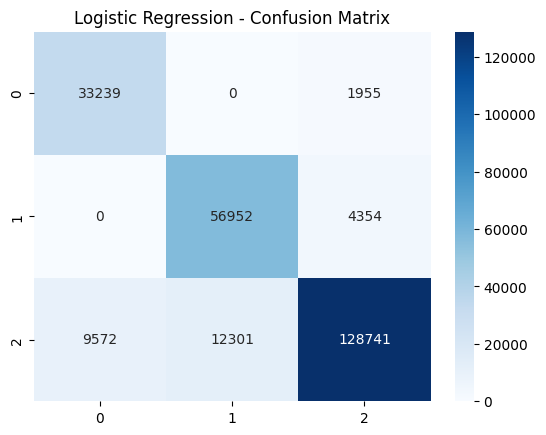

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test)

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


In [10]:
import gc
gc.collect()

5645

Training Random Forest...

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35194
           1       1.00      1.00      1.00     61306
           2       1.00      1.00      1.00    150614

    accuracy                           1.00    247114
   macro avg       1.00      1.00      1.00    247114
weighted avg       1.00      1.00      1.00    247114



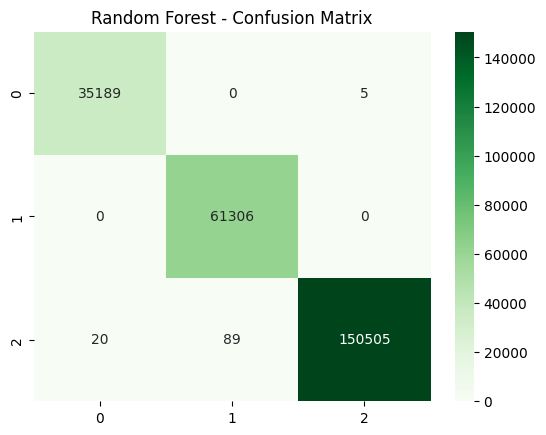

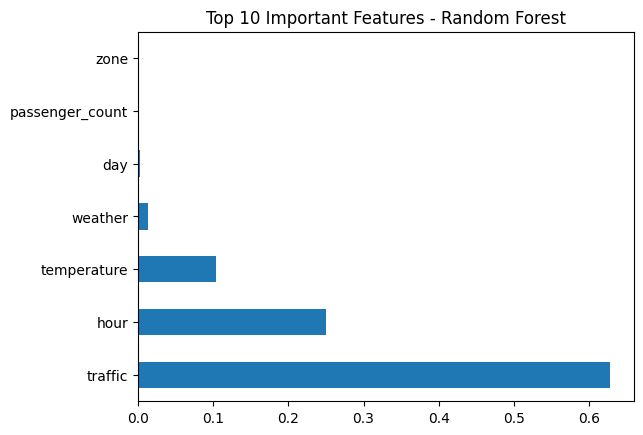

In [11]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=80,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.show()

feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Important Features - Random Forest")
plt.show()


Training LightGBM...

LightGBM Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     35194
           1       1.00      1.00      1.00     61306
           2       1.00      1.00      1.00    150614

    accuracy                           1.00    247114
   macro avg       1.00      1.00      1.00    247114
weighted avg       1.00      1.00      1.00    247114

Weighted F1: 0.997770567548891


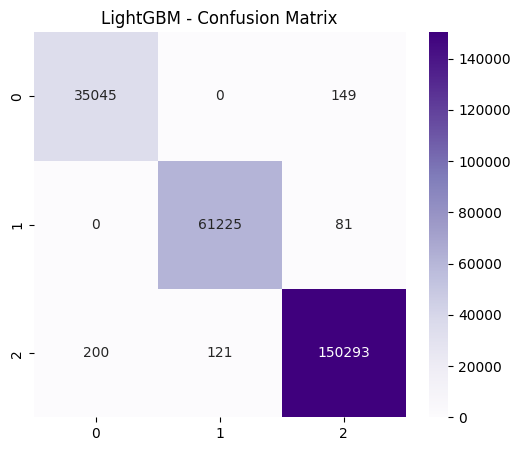

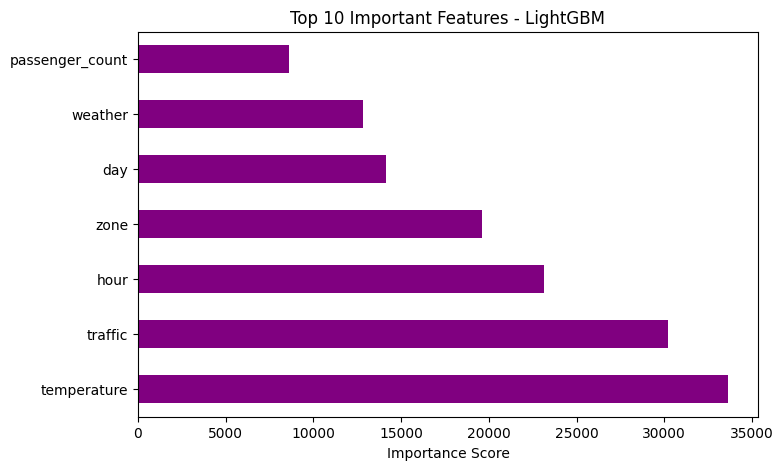


Saving model...

Model saved successfully as:
 - c:\Users\ASUS\OneDrive\Desktop\SurgeSense\models\surge_model.pkl
 - c:\Users\ASUS\OneDrive\Desktop\SurgeSense\models\surge_model.txt


In [25]:
import sys
from pathlib import Path
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import joblib

if 'ipykernel' in sys.modules:
    ROOT_DIR = Path.cwd().parent
else:
    ROOT_DIR = Path(__file__).resolve().parent

MODELS_DIR = ROOT_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Training LightGBM...")
model = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.03,
    num_leaves=80,
    max_depth=-1,
    min_child_samples=30,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train_res, y_train_res)
y_pred_lgb = model.predict(X_test)

print("\nLightGBM Results:")
print(classification_report(y_test, y_pred_lgb))
f1_lgb = f1_score(y_test, y_pred_lgb, average='weighted')
print("Weighted F1:", f1_lgb)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Purples')
plt.title("LightGBM - Confusion Matrix")
plt.show()

feat_imp = pd.Series(model.feature_importances_, index=X_train_res.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
feat_imp.head(10).plot(kind='barh', color='purple')
plt.title("Top 10 Important Features - LightGBM")
plt.xlabel("Importance Score")
plt.show()

print("\nSaving model...")
pkl_path = MODELS_DIR / "surge_model.pkl"
joblib.dump(model, pkl_path)

txt_path = MODELS_DIR / "surge_model.txt"
model.booster_.save_model(str(txt_path))

print("\nModel saved successfully as:")
print(f" - {pkl_path}")
print(f" - {txt_path}")

In [17]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Weighted F1 Score': [f1_lr, f1_rf, f1_lgb]
}).sort_values(by='Weighted F1 Score', ascending=False)

print("\nModel Comparison:")
display(results_df)


Model Comparison:


,Model,Weighted F1 Score
1,Random Forest,0.999539
2,LightGBM,0.997771
0,Logistic Regression,0.887177


In [26]:
import joblib

best_model_name = results_df.iloc[0]['Model']

if best_model_name == 'Logistic Regression':
    best_model = lr
elif best_model_name == 'Random Forest':
    best_model = rf
else:
    best_model = model

joblib.dump(best_model, f"C:/Users/ASUS/OneDrive/Desktop/SurgeSense/models/{best_model_name.replace(' ','_').lower()}_model.pkl")
print(f"Saved best model: {best_model_name}")


Saved best model: Random Forest


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8500\459126540.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Weighted F1 Score', data=results_df, palette='viridis')


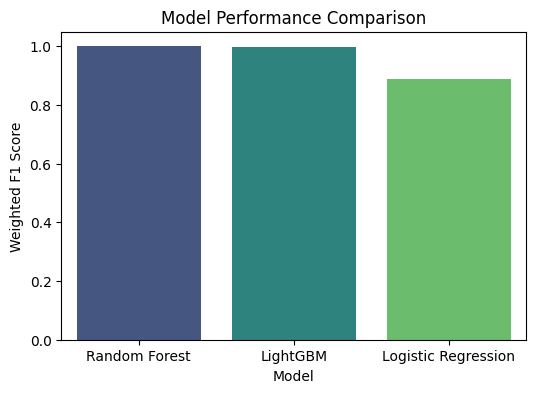

In [27]:
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Weighted F1 Score', data=results_df, palette='viridis')
plt.title("Model Performance Comparison")
plt.show()

In [28]:
import joblib

joblib.dump(model, MODELS_DIR / "surge_model.pkl")
print(f"Model saved as {MODELS_DIR / 'surge_model.pkl'}")

Model saved as c:\Users\ASUS\OneDrive\Desktop\SurgeSense\models\surge_model.pkl


In [29]:
import sys
import joblib
from pathlib import Path

if 'ipykernel' in sys.modules:
    ROOT_DIR = Path.cwd().parent
else:
    ROOT_DIR = Path(__file__).resolve().parent

MODELS_DIR = ROOT_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(encoders, MODELS_DIR / "encoders.pkl")
joblib.dump(le_surge, MODELS_DIR / "surge_label_encoder.pkl")
joblib.dump(feature_names, MODELS_DIR / "feature_names.pkl")

if hasattr(model, 'booster_'):
    model.booster_.save_model(str(MODELS_DIR / "surge_model.txt"))
else:
    model.save_model(str(MODELS_DIR / "surge_model.txt"))

print(f"Files are saved to: {MODELS_DIR}")

Files are saved to: c:\Users\ASUS\OneDrive\Desktop\SurgeSense\models


In [30]:
import sys
import lightgbm as lgb
from pathlib import Path

if 'ipykernel' in sys.modules:
    ROOT_DIR = Path.cwd().parent
else:
    ROOT_DIR = Path(__file__).resolve().parent

MODEL_PATH = ROOT_DIR / "models" / "surge_model.txt"

model = lgb.Booster(model_file=str(MODEL_PATH))
print(model.feature_name())

['passenger_count', 'hour', 'day', 'zone', 'weather', 'temperature', 'traffic']
